# self-attention

## setup

In [658]:
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.decomposition import PCA
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [644]:
EMBED_SIZE = 2
VOCAB_SIZE = 11
HIDDEN_SIZE = 32
CONTEXT_SIZE = 10
MAGIC_TOKEN = VOCAB_SIZE - 1
EPOCHS = 10000
LEARNING_RATE = 3e-4
DROPOUT = 0.1

In [645]:
X = []
Y = []

for i in range(10000):
  magic_token_idx = random.randint(1, CONTEXT_SIZE/2 - 1)
  x = [random.randint(1,VOCAB_SIZE-2) for _ in range(magic_token_idx)] + [MAGIC_TOKEN] + [0 for _ in range(CONTEXT_SIZE - magic_token_idx - 1)]
  y = x[:magic_token_idx+1] + x[:magic_token_idx] + [0 for _ in range(CONTEXT_SIZE - 2 * magic_token_idx - 1)]
  X.append(x)
  Y.append(y)

X = torch.tensor(X).to(device)
Y= torch.tensor(Y).to(device)

## code

In [646]:
activations = {}

class Attention(nn.Module):
  def __init__(self):
    super().__init__()
    self.w_key = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.w_query = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.w_value = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.ln = nn.LayerNorm(EMBED_SIZE)
    self.dropout = nn.Dropout(DROPOUT)

  def forward(self, x):
    # generate K,Q,V
    key = self.w_key(x)
    query = self.w_query(x)
    value = self.w_value(x)
    # pre-layernorm
    x = self.ln(x)
    # do the attention
    correlation = query @ key.transpose(-2, -1)
    correlation = correlation / math.sqrt(key.shape[-1])
    correlation = F.softmax(correlation, dim=-1)
    activations['x'] = correlation.detach()
    new_embedding = correlation @ value
    # post-layernorm
    # new_embedding = self.ln(new_embedding)
    new_embedding = self.dropout(new_embedding)
    return new_embedding

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding = nn.Embedding(VOCAB_SIZE, EMBED_SIZE)
    self.positional_embedding = nn.Embedding(CONTEXT_SIZE, EMBED_SIZE)
    self.attention = Attention()
    self.ff = nn.Sequential(
      nn.LayerNorm(EMBED_SIZE),
      nn.Linear(EMBED_SIZE, HIDDEN_SIZE),
      nn.ReLU(),
      nn.Linear(HIDDEN_SIZE, EMBED_SIZE),
      # nn.LayerNorm(EMBED_SIZE),
      nn.Dropout(DROPOUT)
    )
    self.head = nn.Linear(EMBED_SIZE, VOCAB_SIZE)

  def forward(self, x):
    # (batch_size, context_size)
    x = self.token_embedding(x)  # (batch_size, context_size, embedding_size)
    # positional encoding
    x = x + self.positional_embedding(torch.arange(0, x.shape[1]).to(device))
    # attention
    x = x + self.attention(x)
    # feed forward
    x = x + self.ff(x)
    # head
    x = self.head(x)
    return x

In [ ]:
model = Net().to(device)
positional_embeddings = []

In [660]:
def train(model, epochs=EPOCHS, lr=LEARNING_RATE):
  model.train()
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    out = model(X)
    loss = F.cross_entropy(out.view(-1, out.shape[-1]), Y.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
      positional_embeddings.append(model.positional_embedding.weight.detach().cpu())
    if epoch % 500 == 0:
      print(f'{epoch:5} {loss.item()}')

train(model, epochs=10000, lr=3e-4)

    0 0.6874262690544128
  500 0.6822072863578796
 1000 0.68377685546875
 1500 0.6819071769714355
 2000 0.6798149943351746
 2500 0.6774356365203857
 3000 0.6770448684692383
 3500 0.6946301460266113
 4000 0.6884047389030457
 4500 0.6875560283660889
 5000 0.683821976184845
 5500 0.6814293265342712
 6000 0.6818196773529053
 6500 0.6804237365722656
 7000 0.6772139668464661
 7500 0.6777351498603821
 8000 0.6740654706954956
 8500 0.6729811429977417
 9000 0.6711512207984924
 9500 0.669501781463623


In [ ]:
model.eval()
res = model(X).argmax(-1)
correct = ((res == Y).float().sum(-1) == CONTEXT_SIZE).float().sum()
print(f'accuracy: {correct / len(X)}')
res[:20]

accuracy: 0.031700000166893005


tensor([[ 1, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 7, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  2,  4, 10,  5,  8,  8,  0,  0,  0],
        [ 1,  1, 10,  4,  8,  0,  0,  0,  0,  0],
        [ 6, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 4, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 4,  9,  1,  1, 10,  5,  5,  6,  6,  0],
        [ 5,  6,  5,  5, 10,  5,  5,  6,  6,  0],
        [ 9,  6, 10,  4,  8,  0,  0,  0,  0,  0],
        [ 2,  9,  2,  3, 10,  5,  5,  6,  6,  0],
        [ 6,  3,  3, 10,  5,  8,  8,  0,  0,  0],
        [ 5,  6, 10,  4,  8,  0,  0,  0,  0,  0],
        [ 5,  1,  6, 10,  5,  8,  8,  0,  0,  0],
        [ 4,  2,  2,  3, 10,  5,  5,  6,  6,  0],
        [ 1,  9,  8, 10,  5,  8,  8,  0,  0,  0],
        [ 1,  6, 10,  4,  8,  0,  0,  0,  0,  0],
        [ 6,  2,  3, 10,  5,  8,  8,  0,  0,  0],
        [ 2,  8, 10,  4,  8,  0,  0,  0,  0,  0],
        [ 1,  4,  1,  1, 10,  5,  5,  6,  6,  0],
        [ 5,  1, 10,  4,  8,  0,  0,  0,  0,  0]],

tensor([[ 7,  2,  9,  2, 10,  4,  4,  6,  6,  0]], device='cuda:0')


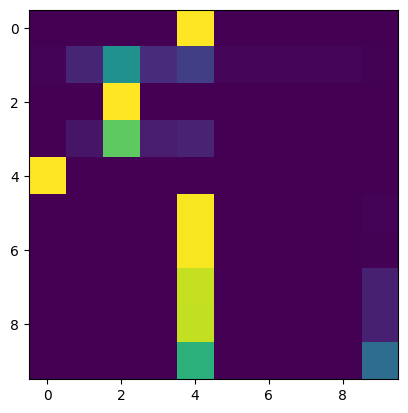

In [650]:
model.eval()
res = model(torch.tensor([[7,1,9,2,10,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[1,2,10,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,10,0,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,3,4,10,0,0,0,0,0,0]]).to(device)).argmax(-1)
print(res)

_ = plt.imshow(activations['x'].squeeze().cpu())

In [651]:
# save
# ----
# torch.save(model.state_dict(), 'weights/copy-task-500k-epochs.pt')

# load
# ----
# m = Net().to(device)
# m.load_state_dict(torch.load('weights/copy-task-500k-epochs.pt'))

## testing ideas

ideas requiring positional encoding / attention:
1) additions using LLM
2) arithmetic / geometric sequence prediction 1, 3, 5 ? → 7  or 2, 4, 8, ? → 16
3) (BOW?) sort 1, 3, 2, 4, 1 → 1, 1, 2, 3, 4
4) parens summation: (2 2 3) (4 5) → 7, 9
5) substring extraction between markers: 1, 4, 56, 10, 43, 54, 56, 6, 10 → 43, 54, 56, 6

## visualize positional embeddings

### dot product

### dotproduct / cosine distance

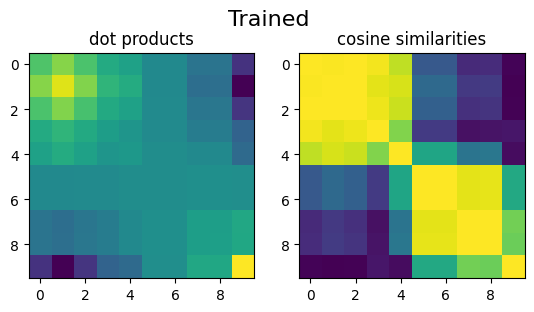

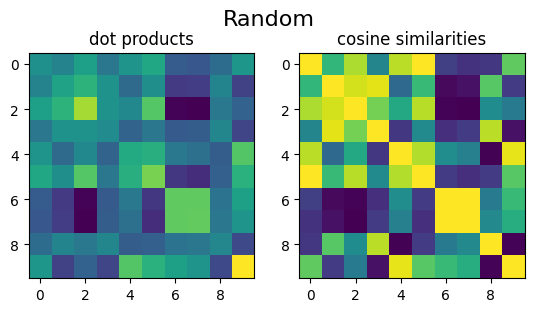

In [652]:
def plot_positional_embeddings_relations(model, title):
    x = model.positional_embedding.weight.data.detach().cpu()
    dot_products = x @ x.T
    x_norm = x / x.norm(dim=1, keepdim=True)
    cosine_similarities = x_norm @ x_norm.T
    # plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(dot_products)
    ax[0].set_title('dot products')
    ax[1].imshow(cosine_similarities)
    ax[1].set_title('cosine similarities')
    fig.text(0.5, 0.8, title, ha='center', va='center', fontsize=16)
    plt.show()

m2 = Net()
plot_positional_embeddings_relations(model, 'Trained')
plot_positional_embeddings_relations(m2, 'Random')

### PCA

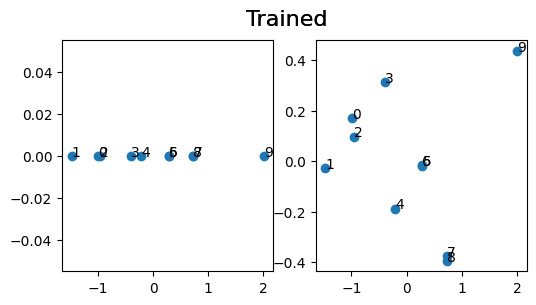

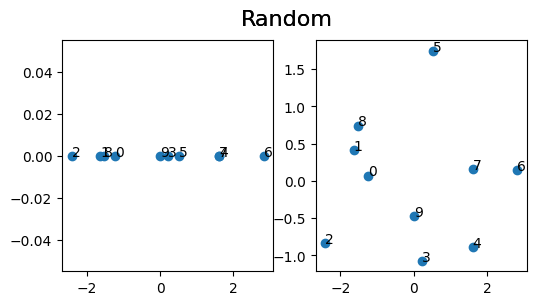

In [653]:
def plot_positional_embeddings_pca(model, title='', figsize=(6, 3)):
    def reduce_dims(x, dim):
        pca = PCA(n_components=dim)
        y = pca.fit_transform(x)
        if dim == 1: return y[:, 0], np.zeros_like(y[:, 0])
        return y[:, 0], y[:, 1]

    x = model.positional_embedding.weight.data.detach().cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for j, dim in enumerate([1, 2]):
        xs, ys = reduce_dims(x, dim)
        # plot
        ax[j].scatter(xs, ys, label='pca dim=2')
        for i in range(xs.shape[0]):
            ax[j].annotate(f'{i}', xy=(xs[i], ys[i]))
        fig.text(0.5, 0.95, title, ha='center', va='center', fontsize=16)

m2 = Net()
plot_positional_embeddings_pca(model, 'Trained')
plot_positional_embeddings_pca(m2, 'Random')

### over time

In [664]:
# bak_positional_embeddings = positional_embeddings

In [663]:
def get_frame(pe, ax):
    def f(step):
        x = pe[step].cpu()
        xs, ys = x[:, 0], x[:, 1]
        ax.clear()
        ax.set_title(f'step {step}')
        ax.scatter(xs, ys, label='')
        for i in range(xs.shape[0]):
            ax.annotate(f'{i}', xy=(xs[i], ys[i]))
        # ax.set_xticks([])
        # ax.set_yticks([])
    return f

def animate_positional_embeddings(pe, figsize=(3, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(pe, ax), frames=len(pe), interval=50, repeat=False)
    plt.close()
    return ani

pes = positional_embeddings[::10]

ani = animate_positional_embeddings(pes)
display(HTML(ani.to_jshtml())) # display inline
# ani.save('maze-dists.gif', fps=20) # save to disk